# Solving the neoclassical model with perturbation

 The following notebook solves and simulates the neoclassical model in the vincinity of its steady-state

In [164]:
using LabelledArrays
using ForwardDiff
using Plots

## Model definition

In [212]:
c = let # calibration
	α = 0.3
	β = 0.96
	γ = 4.0
	δ = 0.1
	ρ = 0.9
	k = ((1/β-(1-δ))/α)^(1/(α-1))
	i = δ*k
	c = k^α - i
	z = 0.0
	ϵ = 0.0
	σ_ϵ = 0.016
	p = SLVector((;α, β, γ, δ, ρ)) # parameters
	s = SLVector((;k,z))           # states
	x = SLVector((;c, i))          # controls
	e = SLVector((;ϵ))             # exogenous shock (iid)
	Σ_e = [[σ_ϵ^2]]  # variance/covariance matrix of the shocks
	(;p, s, x, e, Σ_e)
end

(p = 5-element SLArray{Tuple{5}, Float64, 1, 5, (:α, :β, :γ, :δ, :ρ)} with indices SOneTo(5):
 :α => 0.3
 :β => 0.96
 :γ => 4.0
 :δ => 0.1
 :ρ => 0.9, s = 2-element SLArray{Tuple{2}, Float64, 1, 2, (:k, :z)} with indices SOneTo(2):
 :k => 2.9208221499640707
 :z => 0.0, x = 2-element SLArray{Tuple{2}, Float64, 1, 2, (:c, :i)} with indices SOneTo(2):
 :c => 1.087194911375516
 :i => 0.2920822149964071, e = 1-element SLArray{Tuple{1}, Float64, 1, 1, (:ϵ,)} with indices SOneTo(1):
 :ϵ => 0.0, Σ_e = [[0.000256]])

We now define the equations of the model:
- arbitrage equation: $f(s_t, x_t, s_{t+1}, x_{t+1})$
- transition equation $s_t = g(s_{t-1}, x_{t-1}, \epsilon_t)$

where:
- $s_t$ is a vector of states
- $x_t$ is a vector of controls
- $e_t$ is a vector of exogenous shocks (i.i.d)

In [175]:
function arbitrage(s,x,S,X,p)
	# upper case for variables tomorrow
	r1 = p.β*(X.c/x.c)^(-p.γ)*( (1-p.δ) + p.α*exp(S.z)*S.k^(p.α-1) ) - 1
	r2 = x.c + x.i - exp(S.z)*S.k^p.α
	SLVector((;r1, r2))
end

function transition(s,x,e,p)
	k = s.k * (1-p.δ) + x.i 
	z = s.z * p.ρ + e.ϵ
	SLVector((;k, z))
end

transition (generic function with 2 methods)

In [214]:
# check that the values of s,x,e,p given by the calibration c solve the model at the steady-state
# TODO

## Perturbation

We now compute the derivatives of the model's equations, at the steady-state.

In [217]:
# the object J contains a representation of the first order model
J = let
	(;s, x, p, e, Σ_e) = c
	A = ForwardDiff.jacobian(u->arbitrage(u,x,s,x,p),s)
	B = ForwardDiff.jacobian(u->arbitrage(s,u,s,x,p),x)
	C = ForwardDiff.jacobian(u->arbitrage(s,x,u,x,p),s)
	D = ForwardDiff.jacobian(u->arbitrage(s,x,s,u,p),x)
	E = ForwardDiff.jacobian(u->transition(u,x,e,p), s)
	F = ForwardDiff.jacobian(u->transition(s,u,e,p), x)
	G = ForwardDiff.jacobian(u->transition(s,x,u,p), e)
	(;A,B,C,D,E,F,G)
end

(A = [0.0 0.0; 0.0 0.0], B = [3.679193085018409 0.0; 1.0 1.0], C = [-0.032593562740946457 0.13600000000000007; -0.14166666666666675 -1.379277126371923], D = [-3.679193085018409 -0.0; 0.0 0.0], E = [0.9 0.0; 0.0 0.9], F = [0.0 1.0; 0.0 0.0], G = [0.0; 1.0;;])

In [218]:
function F(X, J)
	# TODO: docstring
	(;A, B, C, D, E, F) = J # equivalent to A=J.A, B=J.B, ...
	return (A+(C+D*X)*E) + (B+(C+D*X)*F)*X
end

distance(A,B) = maximum(abs, (A-B))

function T(X0, J)
	# TODO: docstring
	(;A, B, C, D, E, F) = J # equivalent to A=J.A, B=J.B, ...
	X1 = -(B+(C+D*X0)*F)\(A+(C+D*X0)*E)
end

function solve(J; maxit=1000, τ_η=1e-10, τ_ϵ=1e-8)
	# TODO: docstring
	
	X0 = randn(typeof(J.B))
	for n=1:maxit
		X1 = T(X0, J)
		η = distance(X0, X1)
		X0 = X1
		if η<τ_η
			break
		end
		
	end
	ϵ = maximum(abs, F(X0, J))
	
	# following matrices are such that:
	# s_t = P s_{t-1} + Q e_t
	P = J.E + J.F*X
	Q = J.G

	(;X=X0, P=P, Q=Q, converged=ϵ<τ_ϵ)
end

solve (generic function with 1 method)

In [219]:
# solve the model using linear time iterations
solution = solve(J)

(X = [0.1071898325627176 0.5721253335236988; 0.023662330994892202 0.7796785400516876], P = [0.9236623309691597 0.7796785392232934; 0.0 0.9], Q = [0.0; 1.0;;], converged = true)

In [187]:
# Check that we have indeed found a solution
F(solution.X, J)

2×2 StaticArrays.SMatrix{2, 2, Float64, 4} with indices SOneTo(2)×SOneTo(2):
 8.98548e-12   2.76185e-10
 0.0          -2.22045e-16

## Blanchard-Kahn conditions

In this section we test that the model is well defined by checking the non-explosiveness of simulations, and the contractivity of back-in-time iterations. These two conditions together are often referred to as Blanchard-Kahn conditions.

In [220]:
norm(x::AbstractVector{Float64}) = sqrt(sum(x.^2))/length(x)
norm(x::AbstractMatrix{Float64}) = norm(x[:])

function power_iteration(L, X0; maxit=1000)
	λ = 1
	u0 = rand(typeof(X0))
	u0 = u0/norm(u0)
	for it in 1:maxit
		x1 = L(u0)
		λ = norm(x1)
		u1 = x1/λ
		u0 = u1
	end
	return λ
end

function power_iteration(L::AbstractMatrix; maxit=1000)
	X0 = L[:,1]
	power_iteration(u->L*u, X0)
end

power_iteration (generic function with 3 methods)

In [221]:
λ_B = power_iteration(solution.P) # is it backward stable ?

0.9236623309692881

In [222]:
function Tp(u, J)
	(; A, B, C, D, E, F) = J
	- (B+(C+D*X)*F) \ (D*u*(E+F*X))
end

Tp (generic function with 1 method)

In [224]:
λ_F = power_iteration( u-> Tp(u, J), solution.X) # is it forward stable?

0.8136543191698223

In [235]:
md"""

**Results**

*Solution*

$(solution.X)

*Determinacy conditions*

- backward stability: $(λ_B<=1) 
    - λ\_B = $( λ_B )
- forward stability: $(λ_F<=1)
    - λ\_F = $( λ_F )


"""

**Results**

*Solution*

2×2 StaticArrays.SMatrix{2, 2, Float64, 4} with indices SOneTo(2)×SOneTo(2):
 0.10719    0.572125
 0.0236623  0.779679

*Determinacy conditions*

  * backward stability: true 

      * λ_B = 0.9236623309692881
  * forward stability: true

      * λ_F = 0.8136543191698223


## Non stochastic simulation

In [207]:
TT = 100

Δs = SLVector(k=0.0, z=0.01) # initial *deviation*


2-element SLArray{Tuple{2}, Float64, 1, 2, (:k, :z)} with indices SOneTo(2):
 :k => 0.0
 :z => 0.01

In [208]:
# simulate solution

(;P) = solution


sim_Δs = [( P^i*Δs) for i=1:TT];   # evolution of states

tt = typeof(c.x)  
sim_Δx = [tt(solution.X*Δs...) for Δs in sim_s];   # evolution of controls

sim_Δ = [ [e1; e2] for (e1,e2) in zip(sim_Δs, sim_Δx) ];

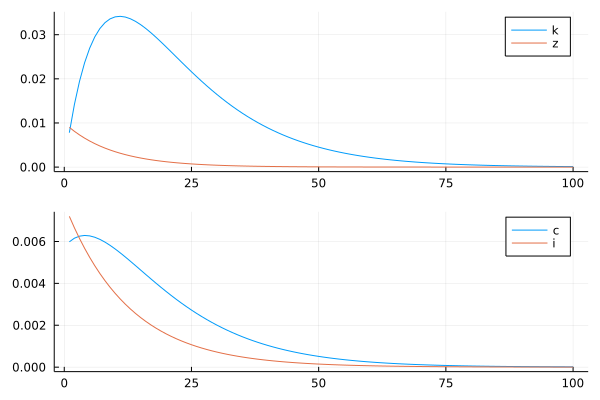

In [209]:

begin 
	pl = plot([e.k for e in sim_Δ], label="k")
	plot!(pl,[e.z for e in sim_Δ], label="z")
pl
	pl2 = plot([e.c for e in sim_Δ], label="c")
	plot!([e.i for e in sim_Δ], label="i")
plot(pl, pl2; layout=(2,1))
end

In [198]:
sim = [ [c.s+e1; c.x+e2] for (e1,e2) in zip(sim_Δs, sim_Δx) ]; # simulation in *levels*

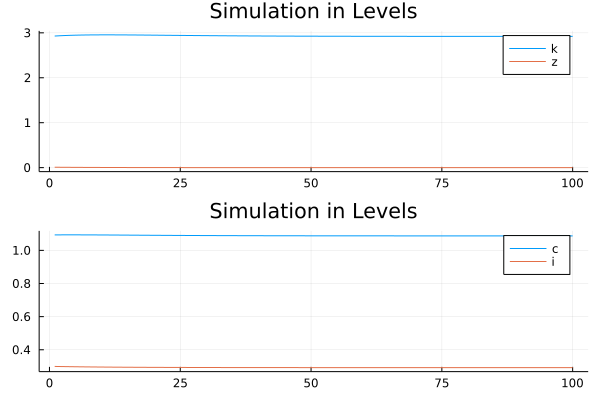

In [199]:
# ╔═╡ aa15857c-064c-4f4b-b661-cd6556dbdbe4
begin 
	pl = plot([e.k for e in sim], label="k")
	plot!(pl,[e.z for e in sim], label="z")
pl
	pl2 = plot([e.c for e in sim], label="c")
	plot!([e.i for e in sim], label="i")
# plot!(pl,[e.z for e in sim])
plot(pl, pl2; layout=(2,1), title="Simulation in Levels")
end